Alexis Ronauli Manurung (2215061109)
> Untuk Tugas UTS Computer Vision

# Import Dataset From Kaggle

In [ ]:
import kagglehub
rizwan123456789_potato_disease_leaf_datasetpld_path = kagglehub.dataset_download('rizwan123456789/potato-disease-leaf-datasetpld')

print('Data source import complete.')


Data source import complete.


---
# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers

----------------------------

# Load Data

In [ ]:
# Paths
Early_Blight_path = '/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training/Early_Blight'
Healthy_path = '/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training/Healthy'
Late_Blight_path = '/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training/Late_Blight'

# Function to get random images
def get_random_images(path, num_samples):
    image_files = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return random.sample(image_files, num_samples)


## Preview the Images

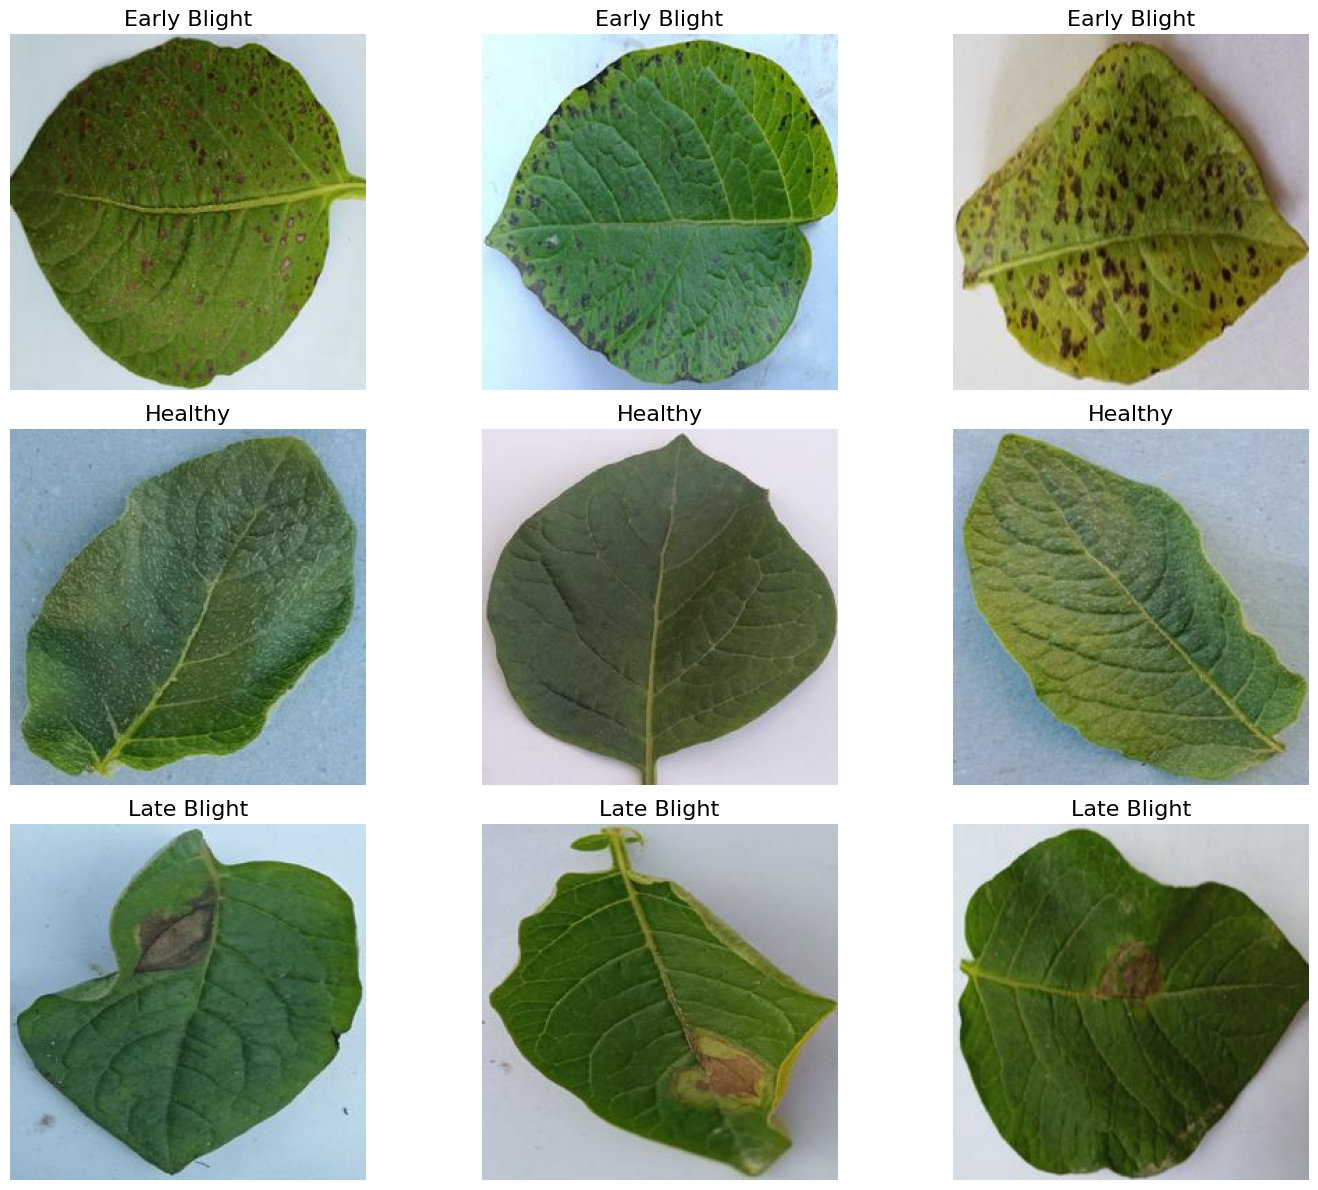

In [ ]:
# Number of samples to display per class
num_samples = 3

# Get samples
early_images = get_random_images(Early_Blight_path, num_samples)
healthy_images = get_random_images(Healthy_path, num_samples)
late_images = get_random_images(Late_Blight_path, num_samples)

# Class labels and images
classes = ['Early Blight', 'Healthy', 'Late Blight']
all_images = [early_images, healthy_images, late_images]

# Plotting
fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 5, 12))

for row, (class_name, images) in enumerate(zip(classes, all_images)):
    for col, image_path in enumerate(images):
        ax = axes[row, col] if num_samples > 1 else axes[row]
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.set_title(class_name, fontsize=16)
        ax.axis('off')

plt.tight_layout()
plt.show()

## `iii` Shape

In [ ]:
# Early Blight
img = mpimg.imread(early_images[0])
print(f"Early Blight : {img.shape}")

# Healthy
img = mpimg.imread(healthy_images[0])
print(f"Healthy : {img.shape}")

# Late Blight
img = mpimg.imread(late_images[0])
print(f"Late Blight : {img.shape}")

Early Blight : (256, 256, 3)
Healthy : (256, 256, 3)
Late Blight : (256, 256, 3)


----------------

#  Preprocessing

In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    directory='/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        '/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Validation',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical'
        )

test_generator = test_datagen.flow_from_directory(
        '/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical'
        )


Found 3251 images belonging to 3 classes.
Found 416 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


----------------

# CNN Model

## Model Design

In [ ]:
# Define the input shape
inputs = Input((256, 256, 3))

# First Convolutional layer with ReLU activation and MaxPooling
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D()(x)

# Second Convolutional layer with ReLU activation and MaxPooling
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D()(x)

# Flatten the output from the convolutional layers
x = Flatten()(x)

# Fully connected Dense layer
x = Dense(64, activation='relu')(x)

# Output layer with sigmoid activation for binary classification
outputs = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs, outputs)

# Display model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,675 (60.14 MB)

 Trainable params: 15,764,675 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

## Model Compilation & Training

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
 history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 402s 4s/step - accuracy: 0.8777 - loss: 0.3532 - val_accuracy: 0.8894 - val_loss: 0.3257
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 406s 4s/step - accuracy: 0.8758 - loss: 0.3610 - val_accuracy: 0.9038 - val_loss: 0.2867
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - accuracy: 0.8950 - loss: 0.3232 - val_accuracy: 0.8798 - val_loss: 0.3238
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 397s 4s/step - accuracy: 0.8935 - loss: 0.3243 - val_accuracy: 0.8846 - val_loss: 0.3590
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - accuracy: 0.8922 - loss: 0.3175 - val_accuracy: 0.8870 - val_loss: 0.2889
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.8877 - loss: 0.3129 - val_accuracy: 0.8918 - val_loss: 0.2981
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - accuracy: 0.8847 - loss: 0.3327 - val_accuracy: 0.8774 - val_loss: 0.3260
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.8894 - loss: 0.3238 - val_accu

## Model Evaluation

In [ ]:
# Evaluate on training data
loss_train, accuracy_train = model.evaluate(train_generator)
print(f"Accuracy (Train): {accuracy_train:.4%}")

# Evaluate on validation data
loss_val, accuracy_val = model.evaluate(validation_generator)
print(f"Accuracy (Validation): {accuracy_val:.4%}")

# Evaluate on test data
loss_test, accuracy_test = model.evaluate(test_generator)
print(f"Accuracy (Test): {accuracy_test:.4%}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9027 - loss: 0.2681
Accuracy (Train): 89.8185%
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 982ms/step - accuracy: 0.9136 - loss: 0.2559
Accuracy (Validation): 91.3462%
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 989ms/step - accuracy: 0.9174 - loss: 0.3109
Accuracy (Test): 89.6296%


## Result Visualization

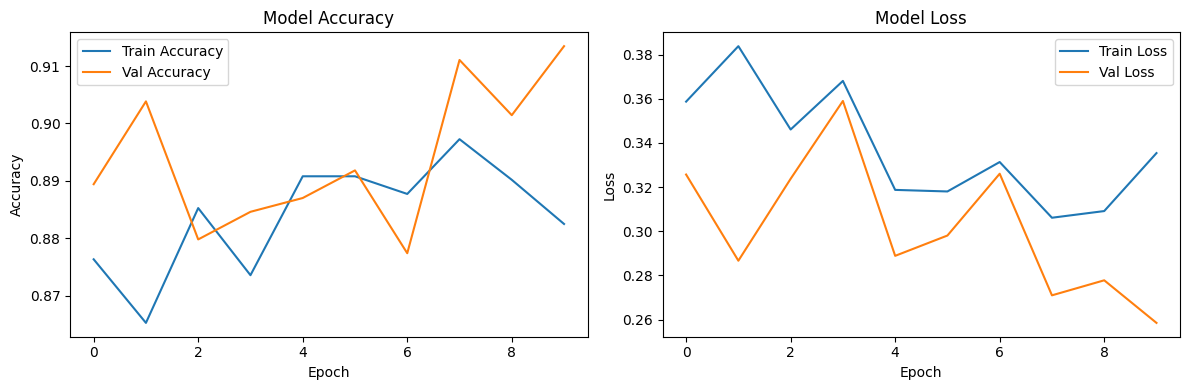

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

----------------

# InceptionResNetV2 Model

## Model Design  

In [ ]:
# Set the input image size
IMG_SIZE = (256, 256)

# Load the InceptionResNetV2 model without the top layer
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freezing the base model layers
base_model.trainable = False

# Create custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=x)


transfer_model.summary()


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 127, 127,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d_2[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 55,913,699 (213.29 MB)

 Trainable params: 1,576,963 (6.02 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

## Model Compilation & Training

In [ ]:
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
transfer_history = transfer_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1460s 14s/step - accuracy: 0.6693 - loss: 1.0038 - val_accuracy: 0.8942 - val_loss: 0.2876
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1361s 13s/step - accuracy: 0.8688 - loss: 0.3324 - val_accuracy: 0.8558 - val_loss: 0.3280
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1415s 14s/step - accuracy: 0.8921 - loss: 0.2877 - val_accuracy: 0.8798 - val_loss: 0.2738
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1419s 14s/step - accuracy: 0.9128 - loss: 0.2341 - val_accuracy: 0.9207 - val_loss: 0.1996
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1459s 14s/step - accuracy: 0.9164 - loss: 0.2125 - val_accuracy: 0.9375 - val_loss: 0.1982
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1397s 14s/step - accuracy: 0.8846 - loss: 0.2825 - val_accuracy: 0.9375 - val_loss: 0.1681
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1361s 13s/step - accuracy: 0.9301 - loss: 0.1917 - val_accuracy: 0.9495 - val_loss: 0.1596
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1409s 14s/step - accuracy: 0.9225 - loss: 0

## Model Evaluation

In [ ]:
# Evaluate on training data
loss_train, accuracy_train = transfer_model.evaluate(train_generator)
print(f"Accuracy (Train): {accuracy_train:.4%}")

# Evaluate on validation data
loss_val, accuracy_val = transfer_model.evaluate(validation_generator)
print(f"Accuracy (Validation): {accuracy_val:.4%}")

# Evaluate on test data
loss_test, accuracy_test = transfer_model.evaluate(test_generator)
print(f"Accuracy (Test): {accuracy_test:.4%}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1226s 12s/step - accuracy: 0.9415 - loss: 0.1557
Accuracy (Train): 94.1249%
13/13 ━━━━━━━━━━━━━━━━━━━━ 151s 12s/step - accuracy: 0.9556 - loss: 0.1317
Accuracy (Validation): 94.7115%
13/13 ━━━━━━━━━━━━━━━━━━━━ 147s 11s/step - accuracy: 0.9527 - loss: 0.1383
Accuracy (Test): 95.5556%


## Result Visualization

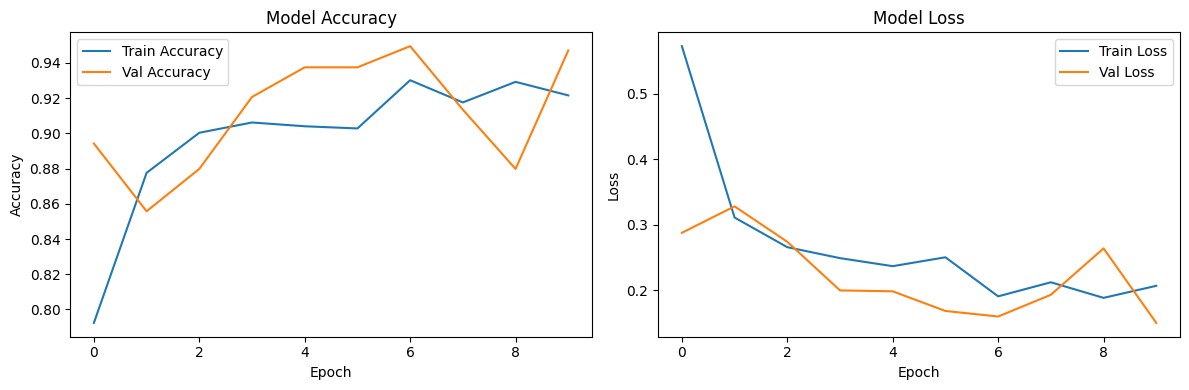

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(transfer_history.history['accuracy'], label='Train Accuracy')
plt.plot(transfer_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(transfer_history.history['loss'], label='Train Loss')
plt.plot(transfer_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


----------------

# Prediction on Random Data

In [ ]:
Early_Blight_path = '/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_1.jpg'
Healthy_path = '/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing/Healthy/Healthy_1.jpg'
Late_Blight_path = '/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing/Late_Blight/Late_Blight_2.jpg'

## Prediction on early blight

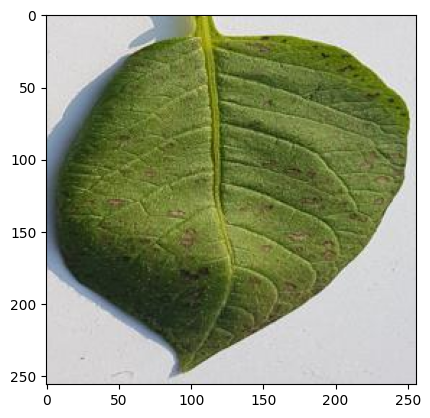

In [ ]:
# Read the image using imread
Early_Blight_image = mpimg.imread(Early_Blight_path)

# Display the image using imshow
plt.imshow(Early_Blight_image)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


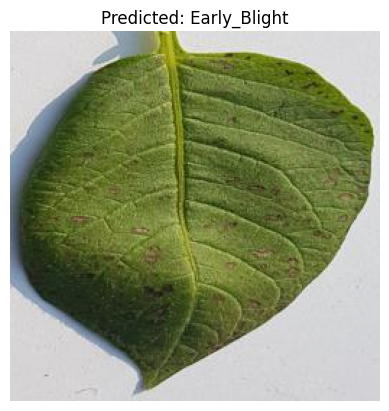

In [ ]:
# Load and preprocess image
img = image.load_img(Early_Blight_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Predict
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

# Get class labels from train_generator
class_labels = list(train_generator.class_indices.keys())

# Show image and prediction
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()

## Prediction on Healthy

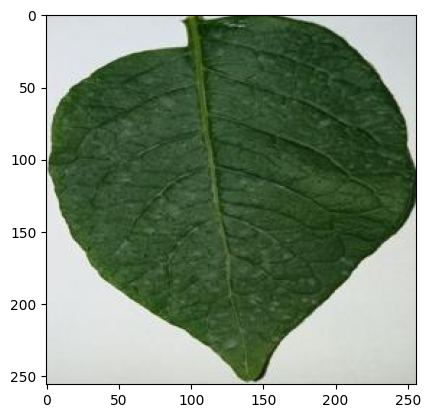

In [ ]:
# Read the image using imread
Healthy_image = mpimg.imread(Healthy_path)

# Display the image using imshow
plt.imshow(Healthy_image)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


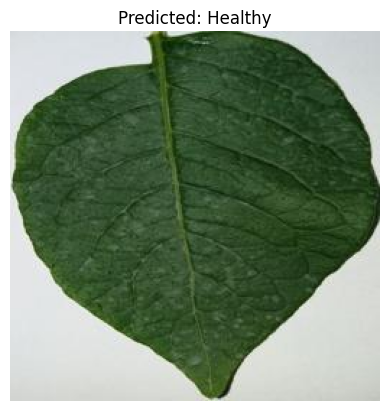

In [ ]:
# Load and preprocess image
img = image.load_img(Healthy_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Predict
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

# Get class labels from train_generator
class_labels = list(train_generator.class_indices.keys())

# Show image and prediction
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()

## Prediction on Late blight

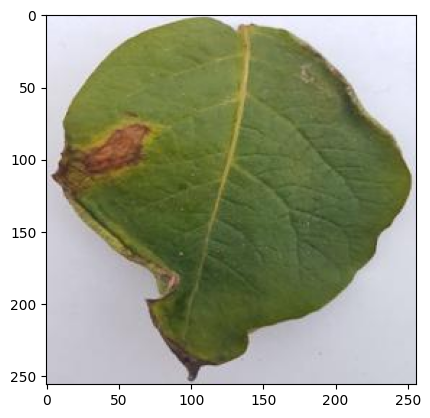

In [ ]:
# Read the image using imread
Late_Blight_image = mpimg.imread(Late_Blight_path)

# Display the image using imshow
plt.imshow(Late_Blight_image)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


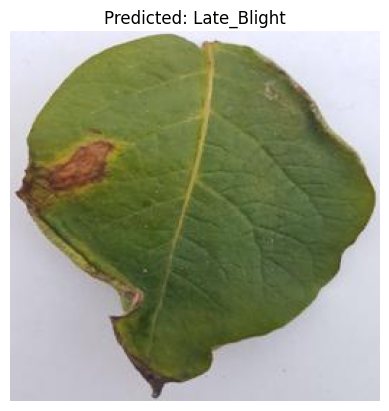

In [ ]:
# Load and preprocess image
img = image.load_img(Late_Blight_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Predict
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

# Get class labels from train_generator
class_labels = list(train_generator.class_indices.keys())

# Show image and prediction
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()